In [1]:
import json
import ollama
import numpy as np
from sklearn.metrics import accuracy_score
import os
import pandas as pd
from evo_prompt import *

In [2]:
path = os.getcwd()

#ONLY USE ONCE TO CREATE TEST SUBSET
"""
data_path = os.path.join(path, "COVID_tweets_dataset", "Corona_balanced.csv")
data = pd.read_csv(data_path)

test_set = pd.concat([
    data[data['Sentiment_float'] == sentiment].sample(n=100, random_state=42)
    for sentiment in [1, 2, 3, 4, 5]
])

test_set.to_csv(os.path.join(path, "COVID_tweets_dataset", "test_set.csv"), index=False)
"""


test_set = pd.read_csv(os.path.join(path, "COVID_tweets_dataset", "test_set.csv"))

In [3]:
def evaluation_function(prompt, dev_set, prompt_source='written', return_invalid_samples=False):
    X = dev_set['OriginalTweet']
    y_true = dev_set['Sentiment_float']
    y_pred = []
    invalid_samples = 0

    for tweet in X:
        if not prompt_source == 'written':
            prompt_cont = prompt.replace("[INSERT TWEET HERE]", tweet)
        else:
            prompt_cont = prompt.replace("[TWEET]", tweet)
        model_response = ollama.chat(model="phi3.5", messages=[
            {
                'role': 'user',
                'content': prompt_cont,
            },
        ], options={
            'temperature': 0.7,
            'num_predict': 1,
            'repeat_penalty': 1,
            'top_k': 10,
            'top_p': 0.9
        })['message']['content']

        # Eventual mapping
        sentiment_mapping = {
            'Negative': 2,
            'Neutral': 3,
            'Positive': 4,
            'Extremely Negative': 1,
            'Extremely Positive': 5
        }

        if model_response in sentiment_mapping.keys():
            model_response = sentiment_mapping[model_response]
        else:
            try:
                model_response = int(model_response)
                if model_response < 1 or model_response > 5:
                    raise KeyError
            except:
                invalid_samples += 1
                model_response = np.random.randint(low=1, high=5)
        y_pred.append(model_response)
        
    accuracy = accuracy_score(y_true, y_pred)
    if return_invalid_samples:
        return accuracy, invalid_samples
    else:
        return accuracy

In [ ]:
#Written prompts EvoPrompt tests
prompter = "written"
prompts_available = 4

json_path = "prompts_examples.json"
with open(json_path, "r") as file:
    prompt_data = json.load(file)

prompts = []
for idx in range(1,prompts_available + 1):
    prompts.append(prompt_data[prompter + "_prompts"]["prompt_" + str(idx)])
population_size = len(prompts)


evoprompt = EvoPrompt(initial_prompts = prompts,
                        dev_set = test_set,
                          evaluation_function=evaluation_function,
                           max_iterations = 20,
                            evolution_method= 'DE')
best_prompt = evoprompt.optimize(print_results=False,
                                 prompts_source= prompter)

print("Best prompt:", best_prompt)

Accuracy progression plot saved to result_graphs/evoprompt_results\accuracy_progression_generated_prompt_GA_20.png


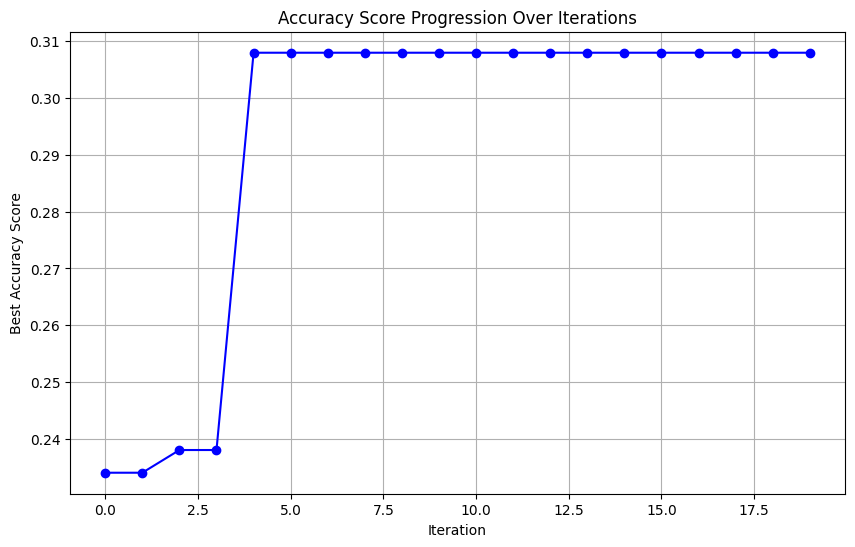

In [11]:
evoprompt.plot_score_progression()

Confusion matrix plot saved to result_graphs/evoprompt_results\conf_matrix_generated_prompt_GA_20.png


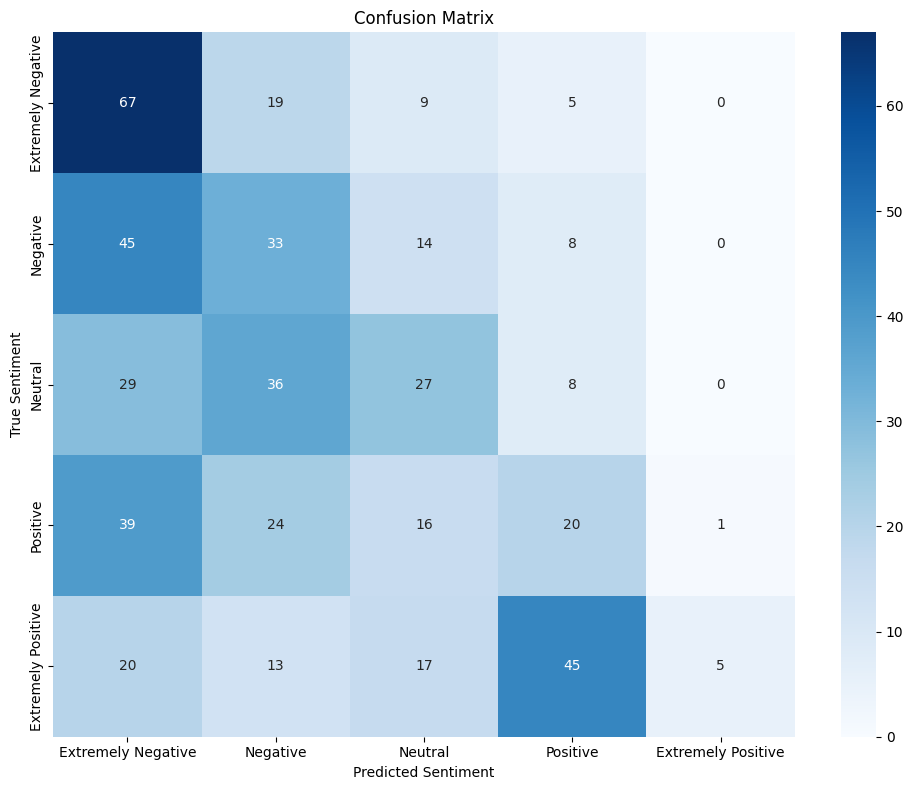

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

prompt = best_prompt
X = test_set['OriginalTweet']
y_true = test_set['Sentiment_float']
y_pred = []
invalid_samples = 0

for tweet in X:
    if not evoprompt.prompts_source == 'written':
        prompt_cont = prompt.replace("[INSERT TWEET HERE]", tweet)
    else:
        prompt_cont = prompt.replace("[TWEET]", tweet)

    model_response = ollama.chat(model="phi3.5", messages=[
        {
            'role': 'user',
            'content': prompt_cont,
        },
    ], options={
        'temperature': 0.7,
        'num_predict': 1,
        'repeat_penalty': 1,
        'top_k': 10,
        'top_p': 0.9
    })['message']['content']


    sentiment_mapping = {
        'Negative': 2,
        'Neutral': 3,
        'Positive': 4,
        'Extremely Negative': 1,
        'Extremely Positive': 5
    }

    if model_response in sentiment_mapping.keys():
        model_response = sentiment_mapping[model_response]
    else:
        try:
            model_response = int(model_response)
            if model_response < 1 or model_response > 5:
                raise KeyError
        except:
            invalid_samples += 1
            model_response = np.random.randint(low=1, high=5)
    y_pred.append(model_response)

evoprompt.plot_conf_matrix(y_true = y_true, y_pred = y_pred)